# Convert keras to tflite 

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Github
%cd 'LacmusTflite'

Mounted at /content/drive/
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/LacmusTflite


In [62]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image
import time
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pandas as pd

saved_model_dir = 'snapshots/B0/'
TFLITE_FILE_PATH = 'model.tflite'

In [63]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 224, 224, 3)
      yield [data.astype(np.uint8)]

In [64]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory

converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

In [65]:
# Save the model.
with open(TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_model)

In [6]:
int_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
int_converter.optimizations = [tf.lite.Optimize.DEFAULT]
int_converter.representative_dataset = representative_dataset
int_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
int_converter.inference_input_type = tf.int8  # or tf.uint8
int_converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = int_converter.convert()

In [7]:
with open('int8_'+TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_quant_model)

## Prepare data 

In [8]:
B = 0
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = EFFICIENT_NET_SIZES[B]
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * 1.2)
os.listdir(DATA_DIR)

['JPEGImages', 'ImageSets', 'Annotations']

In [9]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')[:-1]

test_idxs = [int(t) for t in test_i]

def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, y, _ = o
            yield x, y
        

In [10]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

In [11]:
it = iter(test_gen())

In [12]:
sample = next(it)
sample[0].shape, sample[1].shape

((224, 224, 3), (7, 7))

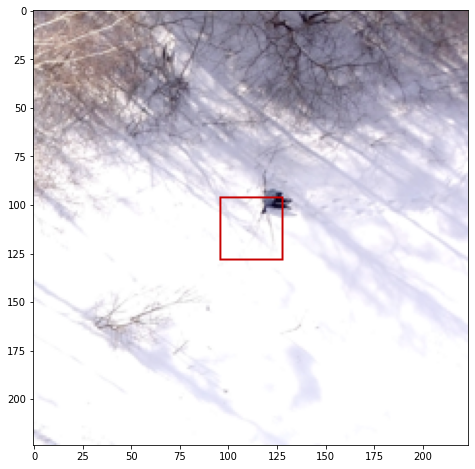

In [13]:
plt.figure(figsize=(8,8))

img_arr = sample[0]
y = sample[1].reshape((7,7))

img = tf.keras.utils.array_to_img(img_arr)
xy = np.array(np.where(y==1)).ravel()[::-1]
bb = np.array([xy, xy+1]).ravel() * 32

draw = ImageDraw.Draw(img)
draw.rectangle(bb.tolist(), outline=(200,0,0))
y_img = Image.fromarray(y*255)
y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))


plt.imshow(img)
plt.show()  

## Load Keras model

In [14]:
import itertools    

it=itertools.islice(it, 65)

In [15]:
sample = next(it)
sample[0].shape, sample[1].shape

((224, 224, 3), (7, 7))

In [16]:
x, y = sample

In [17]:
model = tf.keras.models.load_model(saved_model_dir, compile=False )

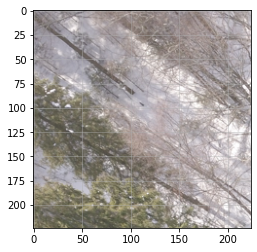

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

major_ticks = np.arange(0, 101, 20)
ax.grid(which='major', alpha=0.5)
plt.imshow(x)
#plt.show()  

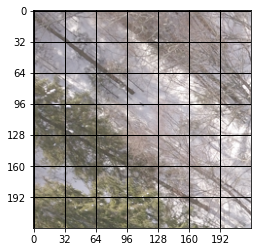

In [19]:
plt.figure()
im = plt.imshow(x)

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 224, 32))
ax.set_yticks(np.arange(0, 224, 32))

#

#

# Gridlines based on minor ticks
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
plt.show()

In [20]:
start = time.time()
pred=model(np.expand_dims(x, 0))
end = time.time()
#normal_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  8907.485723495483 ms


In [21]:
i=0
start = time.time()
while i <1000:
  i+=1
  pred=model(np.expand_dims(x, 0))
end = time.time()
normal_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  17.169151067733765 ms


In [22]:
import seaborn as sns

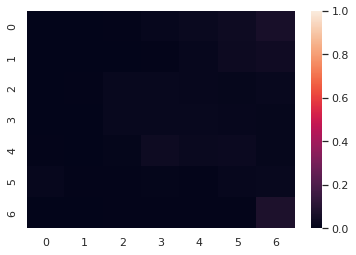

In [23]:

sns.set()
ax = sns.heatmap(pred.numpy().reshape(7, 7), vmin=0, vmax=1)
plt.show()

In [24]:
thresh=0.3

In [25]:
precision = tf.keras.metrics.Precision(thresholds=thresh)
recall = tf.keras.metrics.Recall(thresholds=thresh)
auc = tf.keras.metrics.AUC()

In [26]:
model.compile(metrics=[precision, recall, auc])

In [27]:
start = time.time()
loss,prec,rec,auc =model.evaluate(test_dataset)
end = time.time()
print('time per image: ',(end - start)/sum(1 for x in test_gen())*10**3,'ms')
print(loss,prec,rec,auc)

23/23 [==============================] - 52s 2s/step - loss: 0.0000e+00 - precision: 0.6129 - recall: 0.9120 - auc: 0.9963
time per image:  291.3069791264004 ms
0.0 0.6129032373428345 0.9120000004768372 0.9963394999504089


In [28]:
normal_model_res=['B0',prec,rec,auc]

## Tflite inference 

In [29]:
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)

In [30]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [31]:
interpreter.get_input_details()[0]

{'dtype': numpy.uint8,
 'index': 0,
 'name': 'serving_default_input_1:0',
 'quantization': (0.0, 0),
 'quantization_parameters': {'quantized_dimension': 0,
  'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32)},
 'shape': array([  1, 224, 224,   3], dtype=int32),
 'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
 'sparsity_parameters': {}}

In [32]:
interpreter.get_output_details()

[{'dtype': numpy.float32,
  'index': 517,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1, 1, 1], dtype=int32),
  'shape_signature': array([-1, -1, -1,  1], dtype=int32),
  'sparsity_parameters': {}}]

In [33]:
%%time
start = time.time()
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
quant_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  187.15667724609375 ms
CPU times: user 175 ms, sys: 20.7 ms, total: 196 ms
Wall time: 188 ms


In [34]:
i=0
start = time.time()
while i <1000:
  i+=1
  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
#quant_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  73.85803151130676 ms


In [35]:
start = time.time()
k=180
it = iter(test_gen())
for i in range(k):
  x,y = next(it)

  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/k*(10**3),'ms')

time per image:  158.46199194590253 ms


In [36]:

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter,test_images=test_gen,tresh=0.3):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  start = time.time()
  # Run predictions on every image in the "test" dataset.
  predictions = []
  test_labels=[]
  for test_image in test_gen():
    test_labels.append(test_image[1])
    test_image=test_image[0]
    
    test_image = np.expand_dims(test_image, axis=0).astype(np.uint8)
    interpreter.set_tensor(input_index, test_image)
    
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    pred = interpreter.get_tensor(output_index)
    predictions.append(pred)
  end = time.time()
  print('time per image: ',(end - start)/sum(1 for x in test_gen())*10**3,'ms')
  # Compare prediction results with ground truth labels to calculate accuracy.

  #print(np.array(predictions).reshape((-1)).shape,np.array(test_labels).shape)
  predictions=(np.array(predictions).reshape(-1))
  test_labels=(np.array(test_labels).reshape(-1))
  print (len(predictions))
  tn, fp, fn, tp = confusion_matrix(test_labels,predictions>=tresh).ravel()
  print(tn,fp,fn,tp)
  
  accuracy = (tp+tn)/(fp+fn+tp+tn)
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  fpr, tpr, thresholds =metrics.roc_curve(test_labels, predictions)
  AUC=metrics.auc(fpr, tpr)
  return accuracy,precision,recall,AUC

In [37]:
%%time
print(evaluate_model(interpreter))

time per image:  156.88903199301825 ms
8820
8623 72 10 115
(0.990702947845805, 0.6149732620320856, 0.92, 0.9963335250143761)
CPU times: user 44.6 s, sys: 964 ms, total: 45.6 s
Wall time: 43.3 s


In [38]:
accuracy,precision,recall,AUC=evaluate_model(interpreter)

time per image:  157.99008740319147 ms
8820
8623 72 10 115


In [39]:
quant_res= ['Quant float16',precision,recall,AUC]

In [40]:

interpreter.resize_tensor_input(input_details[0]['index'], (8, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (8, 7,7))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [41]:
%%time
start = time.time()
interpreter.set_tensor(input_details[0]['index'],next(iter(test_dataset))[0])
# Run inference
interpreter.invoke()
# Get prediction results
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/8*(10**3),'ms')

time per image:  522.1199989318848 ms
CPU times: user 4.12 s, sys: 110 ms, total: 4.23 s
Wall time: 4.18 s


In [42]:
normal_time

'17.169151067733765ms'

In [43]:
quant_time

'187.15667724609375ms'

##Testing int8 quantization

In [44]:
int_interpreter = tf.lite.Interpreter('int8_'+TFLITE_FILE_PATH)

In [45]:
int_interpreter.allocate_tensors()

# Get input and output tensors.
input_details = int_interpreter.get_input_details()
output_details = int_interpreter.get_output_details()

In [46]:
%%time
start = time.time()
int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
int_interpreter.invoke()
output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
int_quant_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  1351.3603210449219 ms
CPU times: user 1.35 s, sys: 5.49 ms, total: 1.36 s
Wall time: 1.35 s


In [47]:
i=0
start = time.time()
while i <1000:
  i+=1
  int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
  int_interpreter.invoke()
  output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
#quant_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  1309.2458052635193 ms


In [48]:
start = time.time()
k=180
it = iter(test_gen())
for i in range(k):
  x,y = next(it)

  int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
  int_interpreter.invoke()
  output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/k*(10**3),'ms')

time per image:  1392.5297286775378 ms


In [49]:
print(evaluate_model(int_interpreter))

time per image:  1388.4885562790764 ms
8820
8695 0 125 0
(0.985827664399093, nan, 0.0, 0.47449568717653823)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


In [50]:
accuracy,precision,recall,AUC=evaluate_model(int_interpreter)
int_quant_res= ['Quant int8',precision,recall,AUC]

time per image:  1385.9577284918892 ms
8820
8695 0 125 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


In [51]:
normal_model_res

['B0', 0.6129032373428345, 0.9120000004768372, 0.9963394999504089]

In [52]:
normal_model_res.append(normal_time)
quant_res.append(quant_time)
int_quant_res.append(int_quant_time)

In [61]:
cols=['Model', 'Precision','Recall','auc','inference time']
l=len(cols)
lst = [normal_model_res[:l],quant_res[:l],int_quant_res[:l]]
    
df = pd.DataFrame(lst, columns =cols)[['Model', 'Precision','Recall','inference time']]
df

,Model,Precision,Recall,inference time
0,B0,0.612903,0.912,17.169151067733765ms
1,Quant float16,0.614973,0.920,187.15667724609375ms
2,Quant int8,NaN,0.000,1351.3603210449219ms


In [54]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

In [55]:
# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"custom_loss":focal_loss}
with tf.keras.utils.custom_object_scope(custom_objects):
model = tf.keras.models.load_model(saved_model_dir, custom_objects=custom_objects )

IndentationError: ignored